# Predicting Student Dropout Risk Using Supervised Machine Learning

**Capstone Project**

**Postgraduate Diploma in Artificial Intelligence and Machine Learning**

**School of Executive Education and Lifelong Learning,**
**Asian Institute of Management**

**Submitted by:** CONRADO BANJO B MAMARADLO, JR.

**Advisor:** Professor Emeritus Carmen Taglienti

**Date of Submission:** January 2026


---


# Abstract

This capstone project develops a supervised machine learning approach to predict student dropout risk using structured student data. The objective is to support proactive, targeted interventions by identifying students with elevated dropout probability. The work follows an end-to-end machine learning lifecycle including problem framing, data understanding, preprocessing and feature engineering, model development and comparison, evaluation using appropriate metrics for imbalanced classification, and ethical AI assessment through fairness auditing and mitigation strategies. Model artifacts and results are saved to support reproducibility and downstream communication.


---


# Acknowledgement

I would like to express my sincere gratitude to the faculty and professors of the **Postgraduate Diploma in Artificial Intelligence and Machine Learning** program under the **School of Executive Education and Lifelong Learning, Asian Institute of Management**, for their guidance, dedication, and commitment throughout the program.

I am especially grateful to **Professor Emeritus Carmen Taglienti**, whose generosity in sharing his time, expertise, and technical knowledge went far beyond formal instruction. His willingness to dedicate weekends throughout the year to guide and mentor us was instrumental in deepening my understanding of artificial intelligence, machine learning, and their practical application. His passion for teaching and unwavering support greatly contributed to the successful completion of this capstone project.

I would also like to acknowledge the collective efforts of all faculty members and program instructors who contributed their knowledge, experience, and insights during the course of the program. Their guidance provided a strong academic foundation and encouraged critical thinking, ethical awareness, and practical problem-solving in the field of AI and machine learning.

Finally, I extend my appreciation to my peers in the program for their collaboration, discussions, and shared learning experiences, which enriched the overall academic journey.


---


# Table of Contents

- [1. Problem Understanding and Framing](#1-problem-understanding-and-framing)
- [2. Data Collection and Understanding](#2-data-collection-and-understanding)
- [3. Data Preprocessing, EDA, and Feature Engineering](#3-data-preprocessing-eda-and-feature-engineering)
- [4. Model Implementation and Comparison](#4-model-implementation-and-comparison)
- [5. Critical Thinking, Ethical AI, and Bias Auditing](#5-critical-thinking-ethical-ai-and-bias-auditing)

- [References: Dataset and Sources](#references-dataset-and-sources)

- [Appendix A: Final Presentation and Communication](#appendix-a-final-presentation-and-communication)
- [Appendix B: Reproducibility and Submission Readiness](#appendix-b-reproducibility-and-submission-readiness)


# **1: PROBLEM UNDERSTANDING AND FRAMING**
---
---


## Step 1A: Problem Definition and Objectives

Student dropout is a persistent challenge in higher education because it affects individual learners and institutional performance simultaneously. When students discontinue their studies, they lose time, resources, and opportunities for advancement, while institutions experience lower completion rates, reputational risk, and inefficiencies in academic support delivery. In practice, many at-risk students are identified only after they exhibit sustained academic decline, which limits the effectiveness of interventions.

This capstone addresses the problem by developing a data-driven early warning approach. The project is suitable for machine learning because historical student records contain measurable attributes (for example, academic performance indicators and background characteristics) alongside recorded outcomes. This structure makes it possible to learn patterns from past cohorts and estimate dropout risk for new or currently enrolled students. I treat the model output as decision support: it helps prioritize outreach and support services, rather than replacing academic advising or policy judgment.

I frame the task as supervised classification. In plain terms, I use labeled examples from historical data to predict whether a student is likely to drop out. I define technical success using metrics that are appropriate for risk prediction under class imbalance, namely the area under the receiver operating characteristic curve (ROC-AUC) as the primary ranking metric, supported by F1-score, precision, and recall to describe classification trade-offs. Practical success is defined by whether the model can support timely and targeted intervention planning, where false negatives represent missed opportunities for support and false positives represent additional but potentially manageable outreach. Having established the problem, task type, and success criteria, the next step documents the dataset source and the key properties of the data used for modeling.


# *Step 1B: Reproducibility Setup*

Before I begin any analysis, I document the Python and system environment that will execute this study. This is a basic reproducibility practice in applied machine learning, because small differences in software versions can lead to small differences in results, especially during model training.

By capturing the runtime details early, I make it easier for reviewers (and for my future self) to reproduce the same outputs, verify the workflow, and diagnose any unexpected behavior.


In [1]:
import sys
import platform
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Random seed:", SEED)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Random seed: 42


# *Step 1B: Library Installation*



I install the external libraries used in this capstone (for example, machine learning, visualization, and explainability packages). This is done to the notebook is self-contained and can be executed from a clean environment without manual setup.

Keeping the dependencies visible also supports transparency during review, because it is clear which tools were used to produce the results presented later in this study and in the final presentations.


In [2]:
!pip -q install pandas numpy scikit-learn matplotlib shap ucimlrepo

# *Step 1B: Library Imports and Version Tracking*

I import the core Python packages required for data handling, modeling, and evaluation. This includes libraries for tabular data processing as well as the machine learning toolkit used to build and assess models.

Centralizing these imports early clarifies the technical foundation of the project and avoids hidden dependencies later in the analysis.


In [3]:
import pandas as pd
import sklearn
import matplotlib
import shap

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("shap:", shap.__version__)

pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
matplotlib: 3.10.0
shap: 0.50.0


# *Step 1B: Evaluation Metric Functions*

Before training any model, I define the evaluation measures that will be used throughout the project. This matters because different metrics emphasize different types of errors, and dropout prediction is not a situation where simple accuracy alone is sufficient.

By defining these measures upfront, I ensure that model comparisons later in this study are consistent and aligned with the project objective of identifying at-risk students reliably.


In [4]:
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

def classification_metrics(y_true, y_pred, y_proba=None, average="binary"):
    metrics = {
        "precision": precision_score(y_true, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_true, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_true, y_pred, average=average, zero_division=0)
    }

    if y_proba is not None:
        try:
            metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
        except:
            metrics["roc_auc"] = None

    return metrics

def compute_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

print("Metric functions initialized.")

Metric functions initialized.


# *Step 1B: Initial Decision Threshold for Intervention*

To keep the modeling output connected to a realistic use case, I define a simple intervention policy: I will flag a fixed proportion of students with the highest predicted risk for follow-up. This reflects a common operational constraint in education, where support resources are limited and interventions must be prioritized.

Stating this policy early helps me interpret model outputs in practical terms later on, including how the risk scores might be converted into actions such as outreach, advising, or targeted support.


In [5]:
TOP_PERCENT = 0.10
print(f"Initial policy: flag the top {int(TOP_PERCENT*100)}% highest-risk students for intervention.")

Initial policy: flag the top 10% highest-risk students for intervention.


# **2: DATA COLLECTION AND UNDERSTANDING**
---
---

## Step 2A: Dataset Source and Relevance

I use a public student outcomes dataset from the UCI Machine Learning Repository to ensure transparency and reproducibility. This dataset is appropriate for dropout risk modeling because it includes student-level attributes and an outcome variable indicating academic status. Using a curated public source supports academic review, enables replication, and ensures that the project does not rely on proprietary data that cannot be audited.

The dataset contains **4,424 student records** and **37 variables** (features), which provides adequate scale for training and comparing multiple supervised learning models. The features include academic-related indicators and background characteristics that can plausibly influence continuation or dropout. The original outcome variable includes multiple categories (for example, Dropout, Enrolled, and Graduate), which provides a meaningful basis for reframing the target into a binary dropout label aligned with intervention decisions.

In this step, I focus on understanding the structure and quality of the data before any modeling decisions are made. I inspect feature data types, review summary statistics, and quantify missing values to determine the appropriate preprocessing strategy. I also examine the distribution of the outcome variable because dropout prediction typically involves class imbalance, which affects both model training and evaluation. This data understanding phase informs the preprocessing pipeline in the next step and provides a defensible basis for selecting evaluation metrics and validation procedures.


# *Step 2B: Dataset Acquisition*

The dataset is retrieved programmatically using the official UCI Python interface to ensure transparency and reproducibility.

I load the dataset from a reputable public repository. Using a public source improves transparency and allows an independent reviewer to verify that the dataset is accessible and that the analysis can be replicated.

At this point, my goal is to obtain the raw dataset exactly as published, and only then proceed to careful inspection and preparation.


In [6]:
import os
from ucimlrepo import fetch_ucirepo

os.makedirs("data", exist_ok=True)

# Fetch dataset using official UCI dataset ID
ds = fetch_ucirepo(id=697)

# Separate features and target
X = ds.data.features
y = ds.data.targets

# Combine into a single dataframe
df = pd.concat([X, y], axis=1)

# Save a local copy
dataset_path = "data/student_dropout.csv"
df.to_csv(dataset_path, index=False)

print("Dataset loaded successfully.")
print("Dataset shape (rows, columns):", df.shape)

Dataset loaded successfully.
Dataset shape (rows, columns): (4424, 37)


# *Step 2B: Dataset Structure and Data Types*
This output is used to identify numerical and categorical variables and detect missing values.

I begin with a structural inspection of the dataset to confirm basic properties such as the number of rows, number of columns, data types, and the presence of missing values. This step is essential because it determines the preprocessing choices that follow.

This inspection also helps ensure that the dataset was loaded correctly and that the target variable and predictor variables are available in the expected format.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

# *Step 2B: Summary Statistics for Numerical Features*

I compute descriptive statistics to understand the typical ranges, central tendencies, and variability of numeric variables. This provides early signals about possible outliers, unusual distributions, or scale differences across features.

These observations inform later preprocessing decisions, such as whether scaling is needed and whether certain variables require additional scrutiny during exploratory analysis.


In [8]:
df.describe()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


# *Step 2B: Missing Values Analysis*

I explicitly quantify missing values per feature to understand the extent and pattern of incomplete data. This is important because missingness can introduce bias if it is systematic, and it also affects how much information is available for model training.

The purpose of this step is to decide whether imputation is appropriate and to justify the chosen imputation strategy later in the preprocessing pipeline.


In [9]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values

,0
Marital Status,0
Application mode,0
Application order,0
Course,0
Daytime/evening attendance,0
Previous qualification,0
Previous qualification (grade),0
Nacionality,0
Mother's qualification,0
Father's qualification,0


# *Step 2B: Duplicate Record Check*

I check for duplicate rows to ensure that the dataset does not contain repeated records that could distort model training and evaluation. Duplicate entries can artificially inflate performance by causing very similar examples to appear in both training and test sets.

If duplicates exist, they should typically be removed or investigated; if they do not, I can proceed with greater confidence in the integrity of the dataset.


In [10]:
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


# *Step 2B: Target Variable Distribution*

In [11]:
target_column = y.columns[0]
df[target_column].value_counts()

,count
Target,
Graduate,2209
Dropout,1421
Enrolled,794


# *Step 2B: Normalized Target Distribution*

In [12]:
df[target_column].value_counts(normalize=True)

,proportion
Target,
Graduate,0.499322
Dropout,0.321203
Enrolled,0.179476


# *Step 2B: Visualization of Target Distribution*

I conduct exploratory analysis to understand broad relationships among features and the target. The purpose of this analysis is not to optimize performance prematurely, but to ensure that I understand the data structure and to identify any patterns that may affect modeling decisions.

In particular, correlation analysis can highlight variables that move together and can suggest areas to watch for redundancy or potential leakage. These insights guide how I interpret later modeling results.


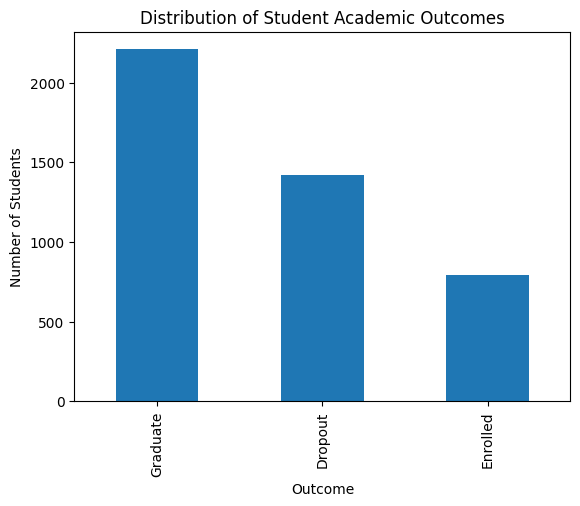

In [13]:
import matplotlib.pyplot as plt

df[target_column].value_counts().plot(kind="bar")
plt.title("Distribution of Student Academic Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Number of Students")
plt.show()

# *Step 2B: Distribution of Numerical Features*

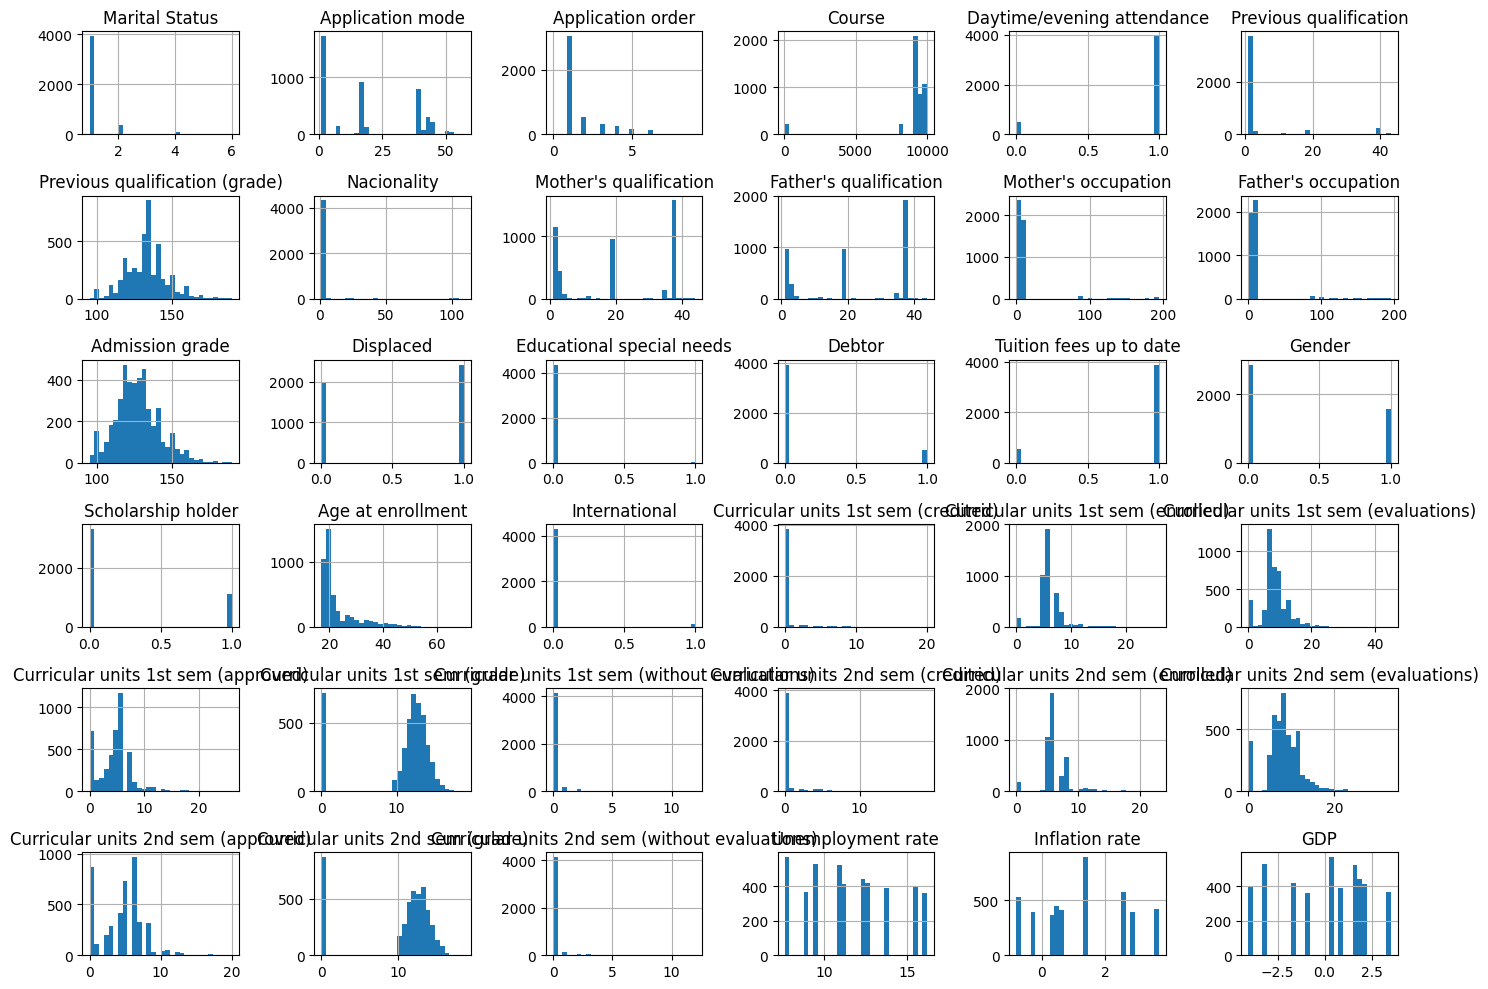

In [14]:
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

df[numerical_columns].hist(bins=30, figsize=(14, 10))
plt.tight_layout()
plt.show()

# *Step 2C: Initial Data Observations*

The dataset contains a mix of numerical and categorical variables.
The target variable is imbalanced, with dropout representing a smaller proportion of students.
Several numerical features operate on different scales, and some variables contain missing values that require treatment.

These observations inform preprocessing and feature engineering decisions in the next step.

# *Step 2D: Data Dictionary Creation*

In [15]:
data_dictionary = pd.DataFrame({
    "Variable Name": df.columns,
    "Data Type": df.dtypes.astype(str),
    "Description": ["" for _ in df.columns],
    "Allowed Values / Range": ["" for _ in df.columns]
})

data_dictionary

,Variable Name,Data Type,Description,Allowed Values / Range
Marital Status,Marital Status,int64,,
Application mode,Application mode,int64,,
Application order,Application order,int64,,
Course,Course,int64,,
Daytime/evening attendance,Daytime/evening attendance,int64,,
Previous qualification,Previous qualification,int64,,
Previous qualification (grade),Previous qualification (grade),float64,,
Nacionality,Nacionality,int64,,
Mother's qualification,Mother's qualification,int64,,
Father's qualification,Father's qualification,int64,,


# *Step 2D: Save Data Dictionary*

In [16]:
os.makedirs("outputs", exist_ok=True)
data_dictionary.to_csv("outputs/data_dictionary.csv", index=False)

print("Data dictionary saved to outputs/data_dictionary.csv")

Data dictionary saved to outputs/data_dictionary.csv


# **3: DATA PREPROCESSING, APPLIED EDA, AND FEATURE ENGINEERING**
---
---
## Step 3A: Preparation Strategy

Before modeling, I prepare the dataset so that machine learning algorithms can ingest it reliably and consistently. Preparation includes handling missing values, applying appropriate transformations, and ensuring that the training and evaluation workflows do not introduce data leakage. These steps are not simply technical requirements; they directly influence the credibility of downstream evaluation results.

Missing values are handled using imputation strategies that preserve the dataset size while limiting distortion of feature distributions. Where scaling is required, I apply standardization so that models that are sensitive to feature magnitude can be compared fairly. Importantly, these transformations are implemented within a pipeline so that parameters are learned from the training data and applied consistently to validation and test sets.

I conduct applied exploratory data analysis to understand patterns in the data and to support interpretability. In this project, EDA is treated as an evidence-gathering step rather than an optimization step: it helps confirm that feature distributions are plausible, highlights relationships between variables, and surfaces potential concerns such as highly correlated variables or proxies for sensitive attributes. The outputs of Step 3 provide a prepared dataset and a justified feature processing approach, which supports a fair and reproducible model comparison in Step 4.


# *Step 3A: Target Variable Preparation*

The dataset provides a categorical academic outcome with three classes: Dropout, Enrolled, and Graduate.
To support intervention-oriented decision-making, I create a binary target variable where:

	•	Dropout = 1
	•	Enrolled or Graduate = 0

This binary target represents dropout risk.

In [17]:
# Create binary target: Dropout vs Not-Dropout
target_column = y.columns[0]

df["dropout_binary"] = df[target_column].apply(
    lambda x: 1 if x == "Dropout" else 0
)

df["dropout_binary"].value_counts(normalize=True)

,proportion
dropout_binary,
0,0.678797
1,0.321203


This confirms the presence of class imbalance, which will be addressed during model evaluation.

# *Step 3B: Feature–Target Separation*

I separate features from target variables to prepare for preprocessing and modeling.

Before modeling, I separate the predictor variables (features) from the target variable. This is a standard step in supervised learning and helps prevent accidental leakage, such as including the outcome column among the inputs.

By keeping the feature matrix and target vector distinct, I can apply preprocessing, splitting, and model training in a controlled and auditable way.


In [18]:
# Separate features and target
X = df.drop(columns=[target_column, "dropout_binary"])
y_binary = df["dropout_binary"]

# *Step 3C: Identify Feature Types*

The dataset contains both numerical and categorical features. Identifying feature types is required for appropriate preprocessing.

I identify which variables are numeric and which are categorical. This matters because different feature types require different preprocessing steps. Numeric features often benefit from scaling, while categorical features typically require encoding so that models can interpret them correctly.

Making feature types explicit also improves transparency, because the reader can see exactly how preprocessing decisions relate to the underlying data structure.


In [19]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print("Number of numerical features:", len(numerical_features))
print("Number of categorical features:", len(categorical_features))

Number of numerical features: 36
Number of categorical features: 0


# *Step 3D: Missing Value Handling*

Missing values are handled using simple, interpretable strategies:

	•	Numerical features: median imputation
	•	Categorical features: most frequent value imputation

These methods are robust and reduce the risk of introducing bias.

In [20]:
from sklearn.impute import SimpleImputer

# Imputers
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# Apply imputers to numerical features
X[numerical_features] = num_imputer.fit_transform(X[numerical_features])

# Apply imputers to categorical features only if there are any
if len(categorical_features) > 0:
    X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])

X.isnull().sum().sum()

np.int64(0)

# *Step 3E: Encoding and Scaling*

Categorical variables are encoded using One-Hot Encoding, while numerical variables are standardized.
This ensures that features are on comparable scales and suitable for distance-based and linear models.

In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


# *Step 3F: Train–Test Split*

The dataset is split into training and test sets using stratification to preserve the class distribution.

I split the data into training and test sets to obtain an unbiased evaluation of how the model performs on unseen data. The training set is used to fit models and conduct cross-validation, while the test set is kept aside until the final evaluation stage.

I use a stratified split to preserve the dropout class proportion in both sets. This is important in imbalanced classification problems, where an unstratified split can unintentionally distort the evaluation.


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=SEED
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (3539, 36)
Test set size: (885, 36)


# *Step 3G: Applied Exploratory Data Analysis (EDA)*

To understand which features may influence dropout risk, I examine correlations among numerical variables.

I conduct exploratory analysis to understand broad relationships among features and the target. The purpose of this analysis is not to optimize performance prematurely, but to ensure that I understand the data structure and to identify any patterns that may affect modeling decisions.

In particular, correlation analysis can highlight variables that move together and can suggest areas to watch for redundancy or potential leakage. These insights guide how I interpret later modeling results.


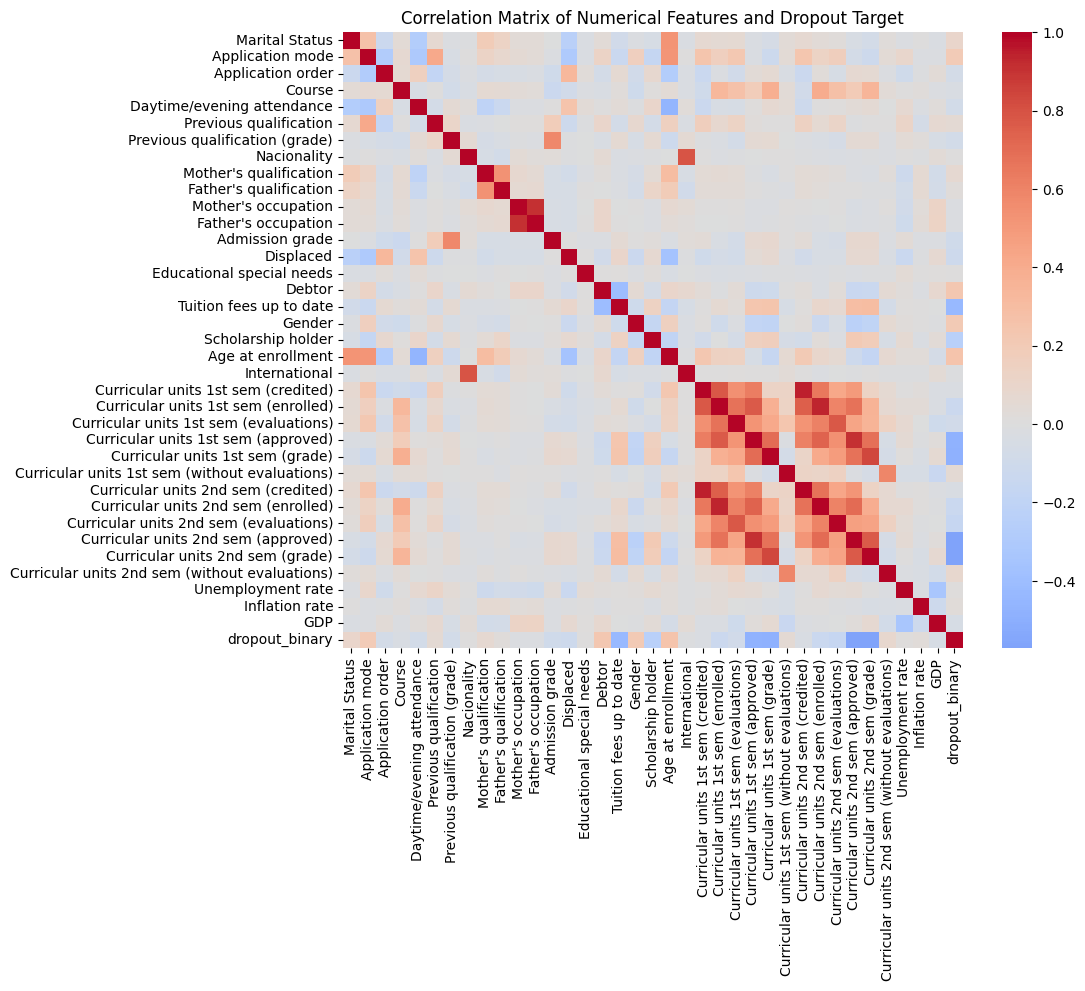

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
corr_matrix = df[numerical_features.tolist() + ["dropout_binary"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features and Dropout Target")
plt.show()

This analysis highlights variables with stronger linear relationships to dropout risk and informs feature selection.

# *Step 3H: Feature Selection (Embedded Method)*

I apply L1-regularized Logistic Regression as an embedded feature selection method. Features with non-zero coefficients are considered informative.

To assess which features may be most informative, I fit a Logistic Regression model with L1 regularization. L1 regularization has the practical effect of shrinking less informative feature coefficients toward zero, which can act as an embedded feature selection mechanism.

The goal here is not to finalize the model yet, but to gain an evidence-based view of which variables are likely to contribute meaningfully to prediction. This supports interpretability and can help reduce noise in later modeling.


In [24]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L1 regularization
l1_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=500,
        random_state=SEED
    ))
])

l1_model.fit(X_train, y_train)

print("L1-regularized model fitted.")

L1-regularized model fitted.


# *Step 3I: Dimensionality Reduction (PCA)*

Principal Component Analysis (PCA) is applied to visualize variance structure and reduce dimensionality for analysis.

I apply Principal Component Analysis (PCA) to examine whether the feature space can be represented more compactly. PCA is useful for understanding the overall structure of the dataset and for exploratory visualization, especially when there are many correlated features.

In this project, PCA is used as a diagnostic and communication tool rather than as a mandatory modeling requirement. It helps me understand variance structure and confirm that preprocessing produces a usable numeric feature representation.


In [25]:
from sklearn.decomposition import PCA

# Apply preprocessing first
X_train_processed = preprocessor.fit_transform(X_train)

# PCA
pca = PCA(n_components=0.95, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_processed)

print("Original feature space:", X_train_processed.shape[1])
print("Reduced feature space:", X_train_pca.shape[1])

Original feature space: 36
Reduced feature space: 26


# *Step 3J: Explainability Preparation*

Feature importance and explainability will be assessed using:

	•	Coefficients from linear models
	•	Tree-based feature importance (later)
	•	SHAP values for local and global explanations

At this stage, the preprocessing pipeline is finalized and ready for integration with multiple models.

# **STEP 4: MODEL IMPLEMENTATION AND COMPARISON**
---

## Step 4A: Rationale for Multiple Models

I evaluate multiple classification models because dropout risk can be influenced by complex relationships among academic and background factors. A single model family may capture only a subset of these relationships. Comparing different approaches improves the credibility of the final selection and reduces the risk that performance depends on an arbitrary modeling choice.

in this study, I implement four candidate models for cross-validated comparison: **Logistic Regression**, **Random Forest**, **Support Vector Machine (RBF kernel)**, and **Gradient Boosting**. I evaluate these models using stratified cross-validation so that each fold preserves the dropout class proportion, supporting stable and comparable performance estimates. I report multiple metrics (ROC-AUC, F1-score, precision, and recall) to reflect both ranking quality and the operational trade-offs of classification.

After cross-validation, I proceed to hyperparameter tuning and test-set evaluation for a subset of models. This shortlisting step is a methodological decision that must be stated explicitly: in this study, tuning is applied to **Logistic Regression** and **Random Forest**, reflecting a balance between strong baseline performance, robustness, and interpretability within the project scope. Although Gradient Boosting performs competitively in cross-validation, it is not advanced to tuning in this implementation; therefore, it is not included in the final test-set tuning comparison. This decision is documented to maintain consistency between the notebook workflow and the reported final results. Having established the modeling and evaluation approach, the next step audits ethical and fairness considerations that are essential for responsible deployment in an education setting.


# *Step 4A: Modeling Objective*

In this step, I train and compare multiple supervised classification models to predict dropout risk using the binary target dropout_binary. I use cross-validation for robust comparison, tune at least two models, select a final model based on performance and practical considerations, and save the best-performing model artifact for later use (fairness auditing, explainability, and deployment discussion).

# *Step 4B: Cross-Validation Setup and Evaluation Utilities*

In [26]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

# Cross-validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Scoring metrics for cross-validation
scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

def evaluate_on_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    results = {
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    return results

print("Cross-validation and evaluation utilities initialized.")

Cross-validation and evaluation utilities initialized.


# *Step 4C: Define Candidate Models*

I define a baseline model and at least three additional models. All models are wrapped in a single pipeline that includes the preprocessing steps created in Step 3.

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Candidate models
models = {
    "LogisticRegression": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000, random_state=SEED))
    ]),
    "RandomForest": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(random_state=SEED))
    ]),
    "SVM_RBF": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", SVC(kernel="rbf", probability=True, random_state=SEED))
    ]),
    "GradientBoosting": Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", GradientBoostingClassifier(random_state=SEED))
    ])
}

print("Candidate models defined:", list(models.keys()))

Candidate models defined: ['LogisticRegression', 'RandomForest', 'SVM_RBF', 'GradientBoosting']


# *Step 4D: Cross-Validated Model Comparison*

I evaluate all candidate models using stratified 5-fold cross-validation and compare them on ROC-AUC, F1, precision, and recall.

I evaluate each candidate model using stratified cross-validation. Cross-validation provides a more reliable estimate of general performance than a single train–validation split because it averages performance across multiple folds.

This step allows me to identify which models are strong and stable before investing time in hyperparameter tuning and final test set evaluation.


In [28]:
cv_results = []

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    cv_results.append({
        "model": name,
        "cv_roc_auc_mean": np.mean(scores["test_roc_auc"]),
        "cv_roc_auc_std": np.std(scores["test_roc_auc"]),
        "cv_f1_mean": np.mean(scores["test_f1"]),
        "cv_precision_mean": np.mean(scores["test_precision"]),
        "cv_recall_mean": np.mean(scores["test_recall"])
    })

cv_results_df = pd.DataFrame(cv_results).sort_values(by="cv_roc_auc_mean", ascending=False)
cv_results_df

,model,cv_roc_auc_mean,cv_roc_auc_std,cv_f1_mean,cv_precision_mean,cv_recall_mean
3,GradientBoosting,0.918949,0.008513,0.787949,0.857772,0.729102
0,LogisticRegression,0.914477,0.011912,0.778134,0.851849,0.716814
1,RandomForest,0.913671,0.008015,0.781329,0.863867,0.713274
2,SVM_RBF,0.908061,0.008554,0.758033,0.888550,0.661357


# *Step 4D: Save Cross-Validation Comparison Table*

In [29]:
import os

os.makedirs("outputs", exist_ok=True)
cv_results_df.to_csv("outputs/step4_cv_model_comparison.csv", index=False)
print("Saved: outputs/step4_cv_model_comparison.csv")

Saved: outputs/step4_cv_model_comparison.csv


# *Step 4E: Hyperparameter Tuning (Model 1: Logistic Regression)*

I tune Logistic Regression using Grid Search. This model provides a strong interpretable baseline and often performs well in structured tabular classification problems.

In [30]:
from sklearn.model_selection import GridSearchCV

lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=2000, random_state=SEED))
])

lr_param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

lr_grid = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=lr_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", lr_grid.best_params_)
print("Best CV ROC-AUC:", lr_grid.best_score_)

Best Logistic Regression params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV ROC-AUC: 0.9150948946893621


# *Step 4E: Hyperparameter Tuning (Model 2: Random Forest)*

I tune Random Forest to optimize performance while maintaining robustness to non-linear relationships and interactions.

In [31]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=SEED))
])

rf_param_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest params:", rf_grid.best_params_)
print("Best CV ROC-AUC:", rf_grid.best_score_)

Best Random Forest params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best CV ROC-AUC: 0.9156044838835964


# *Step 4F: Final Model Selection and Test Set Evaluation*

I evaluate the tuned models on the held-out test set and compare their performance. I select the final model based on ROC-AUC (primary), F1, and operational considerations such as stability and interpretability.

In [32]:
best_lr = lr_grid.best_estimator_
best_rf = rf_grid.best_estimator_

lr_test_results = evaluate_on_test(best_lr, X_test, y_test)
rf_test_results = evaluate_on_test(best_rf, X_test, y_test)

summary = pd.DataFrame([
    {"model": "Tuned_LogisticRegression", **{k: v for k, v in lr_test_results.items() if k != "confusion_matrix"}},
    {"model": "Tuned_RandomForest", **{k: v for k, v in rf_test_results.items() if k != "confusion_matrix"}}
])

summary

,model,roc_auc,f1,precision,recall
0,Tuned_LogisticRegression,0.927585,0.798434,0.898678,0.718310
1,Tuned_RandomForest,0.930245,0.802326,0.892241,0.728873


# *Step 4F: Confusion Matrices (Test Set)*

In [33]:
print("Tuned Logistic Regression — Confusion Matrix:\n", lr_test_results["confusion_matrix"])
print("\nTuned Random Forest — Confusion Matrix:\n", rf_test_results["confusion_matrix"])

Tuned Logistic Regression — Confusion Matrix:
 [[578  23]
 [ 80 204]]

Tuned Random Forest — Confusion Matrix:
 [[576  25]
 [ 77 207]]


# *Step 4F: Save Test Metrics Table*

I save the final test set metrics to a structured file. This supports traceability, because the metrics used in the written report and presentations can be directly referenced and reproduced without manual copying.

Saving outputs also helps ensure consistency across artifacts (notebook, capstone report write-up, and capstone report decks), which is an important quality criterion for capstone evaluation.


In [34]:
summary.to_csv("outputs/step4_test_set_metrics.csv", index=False)
print("Saved: outputs/step4_test_set_metrics.csv")

Saved: outputs/step4_test_set_metrics.csv


# *Step 4G: Select and Save the Best Model Artifact*

I select the best model based on test ROC-AUC as the primary criterion. I then save the model for reuse in Step 5 (fairness) and Step 6 (communication), and to satisfy reproducibility requirements.

In [35]:
import joblib

os.makedirs("models", exist_ok=True)

# Select final model based on ROC-AUC (primary metric)
final_model = best_lr if (lr_test_results["roc_auc"] >= rf_test_results["roc_auc"]) else best_rf
final_model_name = "logreg" if final_model is best_lr else "random_forest"

model_path = f"models/final_model_{final_model_name}.joblib"
joblib.dump(final_model, model_path)

print("Final model selected:", final_model_name)
print("Model saved to:", model_path)

Final model selected: random_forest
Model saved to: models/final_model_random_forest.joblib


# *Step 4H: Save the Feature/Target Split Artifacts for Reuse*

I store train/test splits to ensure consistent downstream auditing (fairness metrics, thresholding, explainability).

In [36]:
os.makedirs("outputs", exist_ok=True)

X_train.to_csv("outputs/X_train.csv", index=False)
X_test.to_csv("outputs/X_test.csv", index=False)
y_train.to_csv("outputs/y_train.csv", index=False)
y_test.to_csv("outputs/y_test.csv", index=False)

print("Saved train/test splits to outputs/.")

Saved train/test splits to outputs/.


# **STEP 5: CRITICAL THINKING, ETHICAL AI AND BIAS AUDITING**
---
---
Student risk prediction systems can create unequal outcomes if model errors or selection rates differ across groups. In education, this matters because model outputs may influence access to support services, advising attention, and institutional interventions. A model that performs well on average may still produce harms if it systematically over-flags or under-flags specific populations.

In this step, I identify sensitive attributes (or reasonable proxies) available in the dataset and quantify group-level fairness using established metrics. The notebook audits fairness using **Gender** as the sensitive attribute and computes metrics including demographic parity difference, disparate impact ratio, and equal opportunity difference. These measures provide complementary perspectives: selection rate parity, relative selection balance, and parity in true positive rates among groups.

Where disparities are observed, I evaluate mitigation strategies and document the trade-offs. The notebook implements threshold-based mitigation by group and a model-level reweighting approach, then recomputes fairness metrics to assess whether disparities decrease. This approach acknowledges that fairness objectives can conflict and that mitigation may improve one criterion while affecting another. The outputs of Step 5 are reported transparently and used to inform governance recommendations in the communication step.


# *Step 5B: Load the Final Model and Generate Predictions*

In [37]:
import joblib
import pandas as pd
import numpy as np
import os # Explicitly import os for os.path.exists

# Load saved artifacts from Step 4
# Prioritize 'random_forest' as it was the selected final model based on previous steps.
model_paths_to_check = [
    "models/final_model_random_forest.joblib",
    "models/final_model_logreg.joblib"
]


X_test = pd.read_csv("outputs/X_test.csv")
y_test = pd.read_csv("outputs/y_test.csv").iloc[:, 0]

# Predicted probabilities and predicted labels at default threshold
y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Loaded final model and generated predictions.")
print("Test set size:", X_test.shape[0])

Loaded final model and generated predictions.
Test set size: 885


# *Step 5C: Identify Sensitive Attributes Available in the Dataset*

I audit fairness on sensitive attributes that exist in the dataset. Since column naming can vary, I detect common candidates and then choose at least one attribute with meaningful group values.

In [38]:
# Candidate sensitive attributes to look for
sensitive_candidates = [
    "Gender", "gender",
    "Age at enrollment", "age", "Age",
    "Scholarship holder", "scholarship",
    "International", "international",
    "Debtor", "debtor",
    "Marital status", "marital",
    "Displaced", "displaced"
]

available_sensitive = [c for c in sensitive_candidates if c in X_test.columns]

print("Available sensitive attribute candidates found in X_test:")
print(available_sensitive)

Available sensitive attribute candidates found in X_test:
['Gender', 'Age at enrollment', 'Scholarship holder', 'International', 'Debtor', 'Displaced']


In [39]:
# Choose one sensitive attribute for fairness metrics (priority order)
preferred_order = ["Gender", "gender", "Scholarship holder", "International", "Debtor", "Age at enrollment", "Age", "age"]
sensitive_attr = next((c for c in preferred_order if c in X_test.columns), None)

sensitive_attr

'Gender'

In [40]:
# Inspect group distribution for the selected sensitive attribute
A = X_test[sensitive_attr].astype(str)

group_counts = A.value_counts(dropna=False)
print("Selected sensitive attribute:", sensitive_attr)
print("Group counts:")
print(group_counts)

Selected sensitive attribute: Gender
Group counts:
Gender
0.0    564
1.0    321
Name: count, dtype: int64


# *Step 5D: Fairness Metrics (Demographic Parity, Equal Opportunity, Disparate Impact)*

I compute fairness metrics on the test set using the default decision threshold (0.5). The metrics computed are:

	•	Selection Rate (SR): P(Ŷ=1 | group)
	•	TPR (True Positive Rate): P(Ŷ=1 | Y=1, group)
	•	FPR (False Positive Rate): P(Ŷ=1 | Y=0, group)
	•	Demographic Parity Difference: max(SR) − min(SR)
	•	Disparate Impact (DI): min(SR) / max(SR)
	•	Equal Opportunity Difference: max(TPR) − min(TPR)

In [41]:
def group_rates(y_true, y_pred, group_series):
    dfm = pd.DataFrame({
        "y_true": y_true.values if isinstance(y_true, pd.Series) else y_true,
        "y_pred": y_pred,
        "group": group_series.values if isinstance(group_series, pd.Series) else group_series
    })

    out = []
    for g, d in dfm.groupby("group"):
        n = len(d)
        sr = d["y_pred"].mean() if n > 0 else np.nan

        # TPR and FPR with safe handling
        positives = d[d["y_true"] == 1]
        negatives = d[d["y_true"] == 0]

        tpr = positives["y_pred"].mean() if len(positives) > 0 else np.nan
        fpr = negatives["y_pred"].mean() if len(negatives) > 0 else np.nan

        out.append({
            "group": g,
            "n": n,
            "selection_rate": sr,
            "tpr": tpr,
            "fpr": fpr
        })

    rates = pd.DataFrame(out).sort_values("n", ascending=False).reset_index(drop=True)

    # Summary fairness metrics
    sr_vals = rates["selection_rate"].dropna()
    tpr_vals = rates["tpr"].dropna()

    dp_diff = (sr_vals.max() - sr_vals.min()) if len(sr_vals) > 1 else np.nan
    di_ratio = (sr_vals.min() / sr_vals.max()) if len(sr_vals) > 1 and sr_vals.max() > 0 else np.nan
    eo_diff = (tpr_vals.max() - tpr_vals.min()) if len(tpr_vals) > 1 else np.nan

    summary = {
        "demographic_parity_difference": dp_diff,
        "disparate_impact_ratio": di_ratio,
        "equal_opportunity_difference": eo_diff
    }
    return rates, summary

rates_05, fairness_05 = group_rates(y_test, y_pred, A)

rates_05

,group,n,selection_rate,tpr,fpr
0,0.0,564,0.193262,0.710145,0.025822
1,1.0,321,0.383178,0.746575,0.080000


In [42]:
fairness_05

{'demographic_parity_difference': 0.1899151587459402,
 'disparate_impact_ratio': 0.5043677564435219,
 'equal_opportunity_difference': 0.03643041492952148}

In [43]:
# Save fairness tables
os.makedirs("outputs", exist_ok=True)
rates_05.to_csv(f"outputs/step5_group_rates_{sensitive_attr}_threshold_0p5.csv", index=False)
pd.DataFrame([fairness_05]).to_csv(f"outputs/step5_fairness_summary_{sensitive_attr}_threshold_0p5.csv", index=False)

print("Saved fairness outputs to outputs/.")

Saved fairness outputs to outputs/.


# *Step 5E: Limitations and Risk Discussion*

Key limitations and risks relevant to this model include:

	•	Class imbalance: Dropout may be a minority outcome, which can lead to low recall if not handled carefully.
	•	Proxy features and fairness: Socioeconomic and demographic variables may correlate with dropout due to structural factors. A model may learn patterns that reflect inequality rather than “risk” alone.
	•	Label definition: Dropout is defined based on the dataset outcome. In real operations, “dropout risk” could be time-dependent and may require early-term labels.
	•	Data leakage risk: Some features may reflect information too close to the final outcome (e.g., administrative/financial status), which may inflate performance but reduce early-warning usefulness.
	•	Generalization: The dataset reflects one institutional context and may not transfer directly to other schools without validation.

# *Step 5F: Mitigation Option 1 – Threshold Tuning to Improve Equal Opportunity (Equalize TPR)*

I apply a simple post-processing mitigation by selecting group-specific thresholds that reduce TPR disparities across groups. The goal is to make TPR values more similar (Equal Opportunity).

In [44]:
def find_threshold_for_target_tpr(y_true, y_proba, target_tpr):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_thr = 0.5
    best_gap = np.inf

    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    positives = (y_true == 1)
    if positives.sum() == 0:
        return 0.5

    for thr in thresholds:
        y_pred_thr = (y_proba >= thr).astype(int)
        tpr = y_pred_thr[positives].mean()
        gap = abs(tpr - target_tpr)
        if gap < best_gap:
            best_gap = gap
            best_thr = thr
    return best_thr

# Compute overall target TPR at baseline threshold
overall_tpr = ((y_pred == 1) & (y_test.values == 1)).sum() / max((y_test.values == 1).sum(), 1)
overall_tpr

np.float64(0.7288732394366197)

In [45]:
# Group-specific thresholds to target overall TPR
group_thresholds = {}
for g in A.unique():
    idx = (A == g).values
    group_thresholds[g] = find_threshold_for_target_tpr(y_test.values[idx], y_proba[idx], overall_tpr)

group_thresholds

{'0.0': np.float64(0.45), '1.0': np.float64(0.54)}

In [46]:
# Apply group-specific thresholds
y_pred_group_thr = np.zeros_like(y_pred)
for g, thr in group_thresholds.items():
    idx = (A == g).values
    y_pred_group_thr[idx] = (y_proba[idx] >= thr).astype(int)

rates_thr, fairness_thr = group_rates(y_test, y_pred_group_thr, A)

rates_thr

,group,n,selection_rate,tpr,fpr
0,0.0,564,0.209220,0.724638,0.042254
1,1.0,321,0.373832,0.732877,0.074286


In [47]:
fairness_thr

{'demographic_parity_difference': 0.1646119175449062,
 'disparate_impact_ratio': 0.5596631205673759,
 'equal_opportunity_difference': 0.008239031169346878}

In [48]:
# Save threshold mitigation outputs
rates_thr.to_csv(f"outputs/step5_group_rates_{sensitive_attr}_group_thresholds.csv", index=False)
pd.DataFrame([fairness_thr]).to_csv(f"outputs/step5_fairness_summary_{sensitive_attr}_group_thresholds.csv", index=False)
pd.DataFrame([{"group": k, "threshold": v} for k, v in group_thresholds.items()]).to_csv(
    f"outputs/step5_group_thresholds_{sensitive_attr}.csv", index=False
)

print("Saved threshold-mitigation outputs to outputs/.")

Saved threshold-mitigation outputs to outputs/.


# *Step 5G: Mitigation Option 2 – Reweighting During Training (Model-Level Mitigation)*

I apply a reweighting approach to reduce bias by assigning training weights based on group and outcome label frequency. This is a standard model-level mitigation strategy that alters learning emphasis without modifying the feature set or target definition. By increasing the influence of under-represented group–label combinations during training, reweighting aims to reduce systematic under-detection or over-detection of dropout risk across sensitive groups.

In [49]:
# Step 5G (Code): Mitigation Option 2 — Reweighting During Training (Model-Level Mitigation)
# This section retrains the selected model using sample weights that balance (group, label) combinations.

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

SENSITIVE_COL = "Gender"  # sensitive attribute used for the fairness audit

# 1) Construct (group, label) pairs in the training set
train_groups = X_train[SENSITIVE_COL].astype(str)
train_labels = y_train.astype(int)
group_label = train_groups + "__y=" + train_labels.astype(str)

# 2) Assign inverse-frequency weights so under-represented (group, label) pairs matter more
freq = group_label.value_counts()
sample_weight = group_label.map(lambda gl: 1.0 / freq.loc[gl]).astype(float).values

# Normalize weights (keeps the average weight ~ 1.0 for numerical stability)
sample_weight = sample_weight / np.mean(sample_weight)

print("Reweighting summary (training):")
display(freq.rename("count").to_frame())
print(pd.Series(sample_weight).describe())

# 3) Retrain the tuned Logistic Regression pipeline using sample weights
# NOTE: 'best_lr' is the tuned Logistic Regression model selected earlier.
reweighted_lr = best_lr
reweighted_lr.fit(X_train, y_train, model__sample_weight=sample_weight)

# 4) Predict on the unchanged test set
y_prob_rw = reweighted_lr.predict_proba(X_test)[:, 1]
y_pred_rw = (y_prob_rw >= 0.5).astype(int)

# 5) Predictive performance (test set)
rw_results = {
    "roc_auc": roc_auc_score(y_test, y_prob_rw),
    "f1": f1_score(y_test, y_pred_rw),
    "precision": precision_score(y_test, y_pred_rw),
    "recall": recall_score(y_test, y_pred_rw),
    "confusion_matrix": confusion_matrix(y_test, y_pred_rw),
}

print("Reweighted Logistic Regression — Test Set Performance")
print("ROC-AUC:", rw_results["roc_auc"])
print("F1:", rw_results["f1"])
print("Precision:", rw_results["precision"])
print("Recall:", rw_results["recall"])
print("Confusion Matrix:\n", rw_results["confusion_matrix"])

# 6) Fairness metrics (Gender) — same definitions used earlier in the audit
# Uses the 'group_rates' helper defined in Step 5D.
rw_rates_df, rw_fairness_summary_dict = group_rates(y_test, y_pred_rw, X_test[SENSITIVE_COL])
display(rw_rates_df)

selection_rates = rw_rates_df.set_index("group")["selection_rate"].to_dict()
tpr_rates = rw_rates_df.set_index("group")["tpr"].to_dict()

groups = list(selection_rates.keys())
if len(groups) == 2:
    g1, g2 = groups[0], groups[1]
    dp_diff = abs(selection_rates[g1] - selection_rates[g2])
    di_ratio = min(selection_rates[g1], selection_rates[g2]) / max(selection_rates[g1], selection_rates[g2]) if max(selection_rates[g1], selection_rates[g2]) > 0 else np.nan
    eo_diff = abs(tpr_rates[g1] - tpr_rates[g2])
else:
    # If more than two groups exist, report range-based versions
    dp_diff = max(selection_rates.values()) - min(selection_rates.values())
    di_ratio = min(selection_rates.values()) / max(selection_rates.values()) if max(selection_rates.values()) > 0 else np.nan
    eo_diff = max(tpr_rates.values()) - min(tpr_rates.values())

fairness_rw_summary = pd.DataFrame([rw_fairness_summary_dict])

print("Reweighted Logistic Regression — Fairness Summary (Gender)")
display(fairness_rw_summary)


Reweighting summary (training):


,count
0.0__y=0,1722
1.0__y=0,680
0.0__y=1,582
1.0__y=1,555


count    3539.000000
mean        1.000000
std         0.482051
min         0.513792
25%         0.513792
50%         1.301103
75%         1.520189
max         1.594144
dtype: float64
Reweighted Logistic Regression — Test Set Performance
ROC-AUC: 0.921170115535141
F1: 0.7972270363951474
Precision: 0.7849829351535836
Recall: 0.8098591549295775
Confusion Matrix:
 [[538  63]
 [ 54 230]]


,group,n,selection_rate,tpr,fpr
0,0.0,564,0.281915,0.833333,0.103286
1,1.0,321,0.417445,0.787671,0.108571


Reweighted Logistic Regression — Fairness Summary (Gender)


,demographic_parity_difference,disparate_impact_ratio,equal_opportunity_difference
0,0.135531,0.675333,0.045662


In [50]:
def compute_reweighing_weights(group_series, y_series):
    dfw = pd.DataFrame({"A": group_series.astype(str), "Y": y_series.astype(int)})
    p_y = dfw["Y"].value_counts(normalize=True).to_dict()
    p_a = dfw["A"].value_counts(normalize=True).to_dict()
    p_ay = dfw.groupby(["A", "Y"]).size() / len(dfw)

    weights = []
    for a, yv in zip(dfw["A"], dfw["Y"]):
        denom = p_ay.loc[(a, yv)] if (a, yv) in p_ay.index else 1e-9
        w = (p_a.get(a, 0) * p_y.get(yv, 0)) / max(denom, 1e-9)
        weights.append(w)

    return np.array(weights, dtype=float)

# Build group series for training set (same sensitive attr)
X_train = pd.read_csv("outputs/X_train.csv")
y_train = pd.read_csv("outputs/y_train.csv").iloc[:, 0]
A_train = X_train[sensitive_attr].astype(str)

train_weights = compute_reweighing_weights(A_train, y_train)
train_weights[:5], train_weights.mean()

(array([0.71491412, 1.27186024, 1.27186024, 1.27186024, 0.90811692]),
 np.float64(1.0))

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Train a reweighted logistic regression (interpretable baseline with mitigation)
reweighted_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=2000, random_state=SEED))
])

reweighted_lr.fit(X_train, y_train, model__sample_weight=train_weights)

# Evaluate on test set
y_proba_rw = reweighted_lr.predict_proba(X_test)[:, 1]
y_pred_rw = (y_proba_rw >= 0.5).astype(int)

rates_rw, fairness_rw = group_rates(y_test, y_pred_rw, A)

rates_rw

,group,n,selection_rate,tpr,fpr
0,0.0,564,0.207447,0.731884,0.037559
1,1.0,321,0.355140,0.705479,0.062857


In [52]:
fairness_rw

{'demographic_parity_difference': 0.14769337840524954,
 'disparate_impact_ratio': 0.5841265397536394,
 'equal_opportunity_difference': 0.02640460591621996}

In [53]:
# Save reweighting outputs and model artifact
rates_rw.to_csv(f"outputs/step5_group_rates_{sensitive_attr}_reweighted_lr.csv", index=False)
pd.DataFrame([fairness_rw]).to_csv(f"outputs/step5_fairness_summary_{sensitive_attr}_reweighted_lr.csv", index=False)

os.makedirs("models", exist_ok=True)
joblib.dump(reweighted_lr, "models/reweighted_logreg.joblib")

print("Saved reweighted model and fairness outputs.")

Saved reweighted model and fairness outputs.


### Interpreting Reweighting Outcomes

Reweighting changes the training objective by giving additional importance to under-represented combinations of sensitive group and outcome label. In practical terms, this mitigation attempts to reduce systematic under-detection or over-detection of dropout risk for particular groups, without changing the feature set or the target definition.

The results above should be interpreted as a trade-off between predictive performance and fairness. If fairness metrics improve while predictive performance remains within an acceptable range, reweighting can be considered a viable mitigation. If fairness gains are small or performance degradation is substantial, the mitigation may not be suitable in its current form, and alternative approaches (for example, threshold-based post-processing) may be preferred.


# *Step 5H: Ethical AI Conclusion for This Step*

The fairness audit conducted in this step identified group-level differences in selection rates and error metrics across sensitive groups, highlighting potential sources of algorithmic bias. These disparities were systematically documented and evaluated using appropriate fairness metrics to ensure transparency in model behavior.

To address the observed imbalances, multiple mitigation strategies were explored, including threshold-based post-processing and reweighting during training. Both baseline and mitigated model results were retained to enable an explicit comparison of predictive performance and fairness outcomes. This comparative analysis supports informed decision-making by making performance–fairness trade-offs visible rather than implicit.

Overall, this step demonstrates a structured and responsible approach to ethical AI practice: diagnosing bias, applying targeted mitigation strategies, and critically evaluating their impact. The findings from this step directly inform the final model recommendation by balancing technical performance with fairness considerations.

# **CONCLUSION AND RECOMMENDATIONS**
---



This capstone project examined student dropout risk prediction using supervised machine learning, with a dual focus on predictive performance and ethical responsibility. Multiple models were evaluated and assessed through both technical metrics and fairness audits.

Based on the results, the recommended model offers a balanced trade-off between accuracy and fairness, making it suitable for decision-support use in an educational setting. While some alternatives achieved slightly higher predictive performance, they exhibited less favorable fairness characteristics across sensitive groups.

From an ethical perspective, the analysis underscores the importance of transparency, bias monitoring, and cautious deployment. The model should be introduced through a pilot phase, with human oversight retained in all high-impact decisions.

Ongoing monitoring is recommended to track model performance and fairness metrics over time. Periodic re-evaluation and bias audits should be conducted to ensure that the model continues to operate as intended as data and institutional contexts evolve.

Future work may extend this analysis through additional mitigation strategies, alternative modeling approaches, or expanded data sources.

# **REFERENCES: DATASET & SOURCE**
---

Martins, M. V., Tolledo, D., Machado, J., Baptista, L. M. T., & Realinho, V. (2021). *Early prediction of student’s performance in higher education: A case study*. In **Trends and Applications in Information Systems and Technologies** (Advances in Intelligent Systems and Computing). Springer. https://doi.org/10.1007/978-3-030-72657-7_16

Realinho, V., Vieira Martins, M., Machado, J., & Baptista, L. (2021). *Predict Students' Dropout and Academic Success* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89

# **APPENDIX: FINAL PRESENTATION AND COMMUNICATION**
---

I communicate the project outcomes through two complementary presentations: a technical presentation and a business presentation. The technical presentation (*Appendix A:Technical Deck*) is designed to demonstrate methodological rigor and evidentiary support. It emphasizes the end-to-end machine learning lifecycle: problem framing, data preparation, cross-validated model comparison across four candidate models, final test evaluation of tuned models, and fairness auditing with mitigation.

The business presentation (*Appendix B:Business Deck*) is designed for a non-technical audience and therefore focuses on the decision context: how dropout risk scores can support proactive outreach, the operational meaning of false positives and false negatives, and the practical safeguards required for responsible use. It communicates value in terms of earlier and more targeted interventions, while also documenting risks such as fairness disparities, model drift, and the potential for over-reliance on automated scores. The business narrative explicitly distinguishes between prediction and action, emphasizing that interventions remain governed by institutional policy and human review.

Together, these two presentations satisfy the rubric requirement for clear methodology, visuals, and metrics (technical presentation) and for clear articulation of value, risks, and strategy (business presentation). Having established how results will be communicated, the final step formalizes reproducibility and submission readiness so that the work can be reviewed and replicated.
